# Preparation

In [15]:
import scanpy as sc
import numpy as np
import os
import anndata2ri
import pathlib
import scvelo as scv
from scipy import io
import anndata#
import pandas as pd
from tqdm import tqdm
import argparse
import sys
import re
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
# sc.logging.print_versions()

import warnings
warnings.filterwarnings("ignore")

outdir = "/home/hieunguyen/CRC1382/outdir"
PROJECT = "SAlBounny_full"
path_to_loom_data = os.path.join(outdir, PROJECT, "velocyto_output")
output_version = "20241021"

object_name = "SAlBounny_full.filter_contaminated_cells.clusterRes_0.5_subcluster_gene_Izumo1r"

path_to_main_output = os.path.join(outdir, PROJECT, output_version, "data_analysis")
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_02_output = os.path.join(path_to_main_output, "02_output")
path_to_03_output = os.path.join(path_to_main_output, "03_output")
path_to_08_output = os.path.join(path_to_main_output, "08_output")

path_to_seurat2anndata = os.path.join(path_to_08_output, "seurat2anndata")

#####------------------------------------------------------------#####
##### READ LOOM DATA
#####------------------------------------------------------------#####
all_looms = [item for item in pathlib.Path(path_to_loom_data).glob("*.loom")]

velodata_dict = dict()
for input_loom in tqdm(all_looms):
    velodata = scv.read_loom(input_loom)
    if "200709" in input_loom.name:
        samplename = input_loom.name.replace("SAlBounny_200709_", "").replace(".loom", "")
    else:
        samplename = input_loom.name.replace("SAlBounny_", "").replace(".loom", "")

    new_obs = ["{}_{}_{}-1".format(samplename, samplename, item.split(":")[1].replace("x", "")) for item in velodata.obs.index]
    velodata.obs.index = new_obs
    velodata.obs["barcode"] = new_obs
    velodata.var_names_make_unique()
    pattern = re.compile('_[A|T|G|C]*-')
    new_obs = [samplename + pattern.search(string = item).group() + item.split("-")[1]
              for item in velodata.obs.index]
    velodata.obs.index = new_obs
    velodata_dict[samplename] = velodata
    velodata.var_names_make_unique()

all_velodata = velodata_dict[list(velodata_dict.keys())[0]]
for data in list(velodata_dict.keys())[1:]:
    all_velodata = all_velodata.concatenate(velodata_dict[data])
    
new_obs = [item.split("-")[0] + "-1" for item in all_velodata.obs.index]
all_velodata.obs.index = new_obs
all_velodata.var_names_make_unique()

#####------------------------------------------------------------#####
##### READ ANNDATA
#####------------------------------------------------------------#####
adata = sc.read_h5ad(os.path.join(path_to_seurat2anndata, '{}.h5ad'.format(object_name)))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


100%|██████████| 7/7 [00:37<00:00,  5.37s/it]


In [27]:
all_velodata

AnnData object with n_obs × n_vars = 26037 × 32285
    obs: 'barcode', 'batch', 'Clusters', '_X', '_Y', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [28]:
merge_data

AnnData object with n_obs × n_vars = 10558 × 1547
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'name', 'stage', 'percent.mt', 'percent.ribo', 'No.Exprs', 'log10GenesPerUMI', 'nCount_decontX', 'nFeature_decontX', 'AmbientRNA', 'decontX_clusters', 'Doublet_classifications', 'percent.exclude', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'G1.Score', 'CC.Difference', 'integrated_snn_res.0.5', 'seurat_clusters', 'cluster_Izumo1r', 'plot.cluster', 'celltype', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch', 'batch', 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'sp

# Main analysis

## Pre-processing pipeline, prepare for RNA velocity analysis

In [16]:
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(all_velodata)
merge_data = scv.utils.merge(adata, all_velodata)

scv.pp.filter_genes(merge_data, min_shared_counts=20)
scv.pp.normalize_per_cell(merge_data)
scv.pp.filter_genes_dispersion(merge_data, n_top_genes=2000)
scv.pp.log1p(merge_data)

scv.pp.filter_and_normalize(merge_data, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(merge_data, n_pcs=30, n_neighbors=30)

Filtered out 10937 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Filtered out 453 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:03)
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## RNA velocity inference

In [17]:
# scv.tl.recover_dynamics(merge_data, n_jobs = 15)
# scv.tl.velocity(merge_data, mode="dynamical", diff_kinetics = True)
scv.tl.velocity(merge_data)
scv.tl.velocity_graph(merge_data)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/28 cores)


  0%|          | 0/10558 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## RNA velocity on UMAP

In [18]:
colordf = pd.read_csv("/home/hieunguyen/CRC1382/outdir/SAlBounny_full/20241021/data_analysis/06_output/colordf.csv", index_col = [0])
colordf.set_index("V1", inplace = True)
colordf =  colordf.loc[['Anergic', 
                       'Early activation/Trm', 
                       'IFN_1', 
                       'Intermediate', 
                       'Late activation', 
                       'Naive/Tcm', 
                       'Proliferation', 
                       'Tregs']]

colors = colordf["color"].to_list()

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


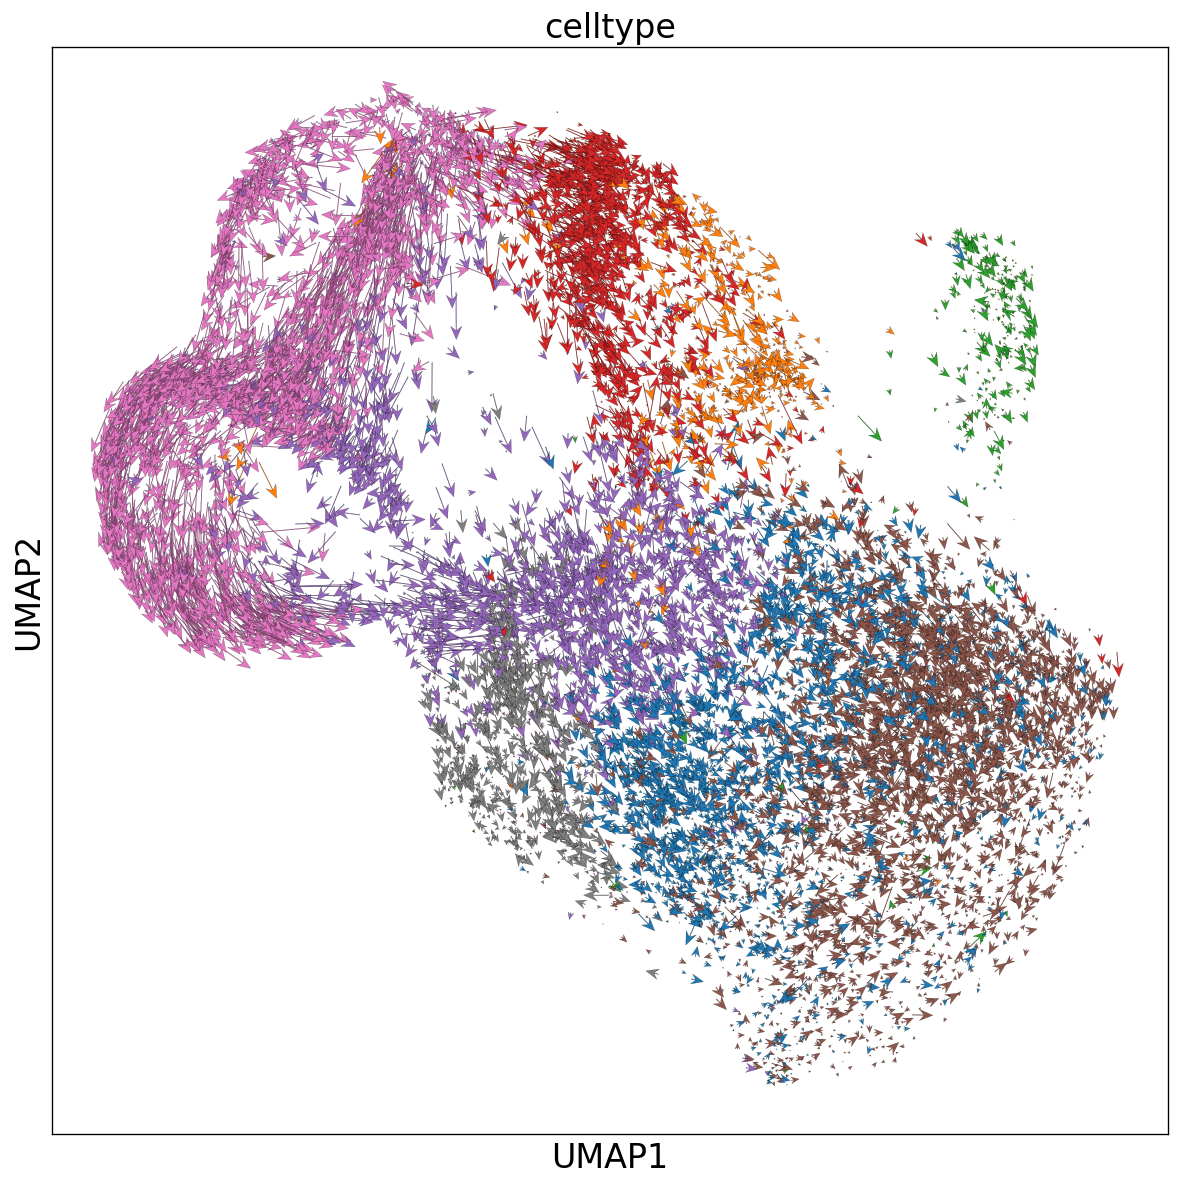

In [19]:
scv.pl.velocity_embedding(merge_data, 
                          dpi=120, 
                          arrow_size=2, 
                          arrow_length=10, 
                          basis = "X_umap",
                          color="celltype",
                         figsize = (12, 12), 
                         fontsize=20, 
                         legend_fontsize=40, 
                         palette = colors,  
                         frameon=True)

## Streamlines

saving figure to file ./figures/scvelo_streamline_SAlBounny_full.filter_contaminated_cells.clusterRes_0.5_subcluster_gene_Izumo1r.svg


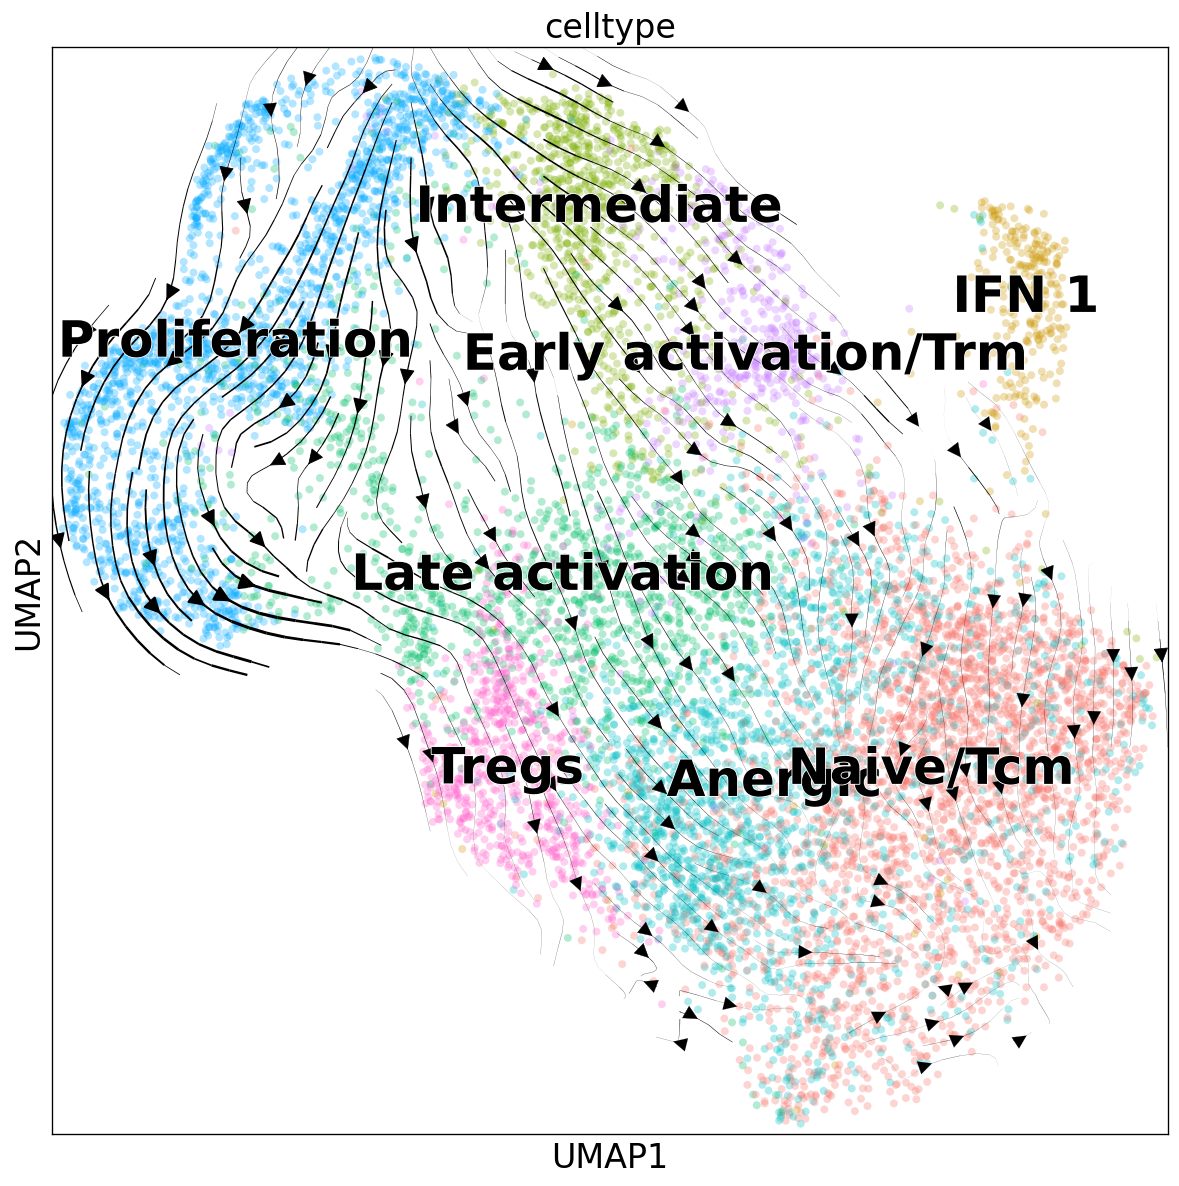

In [20]:
scv.pl.velocity_embedding_stream(merge_data, 
                                 dpi=120, 
                                 arrow_size=2, basis = "X_umap",
                                 color="celltype",
                         figsize = (12, 12), 
                         fontsize=20, 
                         legend_fontsize = 30, 
                         frameon=True, 
                         palette = colors, 
                         save="streamline_{}.svg".format(object_name))

# Interpretation of the RNA velocities

## Gene ranking



We can test which genes have cluster-specific differential velocity expression, being siginificantly higher/lower compared to the remaining population. Run a differential velocity t-test and outpus a gene ranking for each cluster. Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.

In [21]:
scv.tl.rank_velocity_genes(merge_data, groupby='seurat_clusters', min_corr=.3)

df_gene_ranking = scv.DataFrame(merge_data.uns['rank_velocity_genes']['names'])

ranking velocity genes


/home/hieunguyen/miniconda3/envs/hieunguyen/lib/python3.10/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:03) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/tmp/ipykernel_641753/2957559194.py:3: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df_gene_ranking = scv.DataFrame(merge_data.uns['rank_velocity_genes']['names'])


### Display top-10 genes for each group (by cell clusters)

In [22]:
display(df_gene_ranking.head(10))

,0,1,2,3,4,5,6,7,8
0,Ddx39,Ccnb1,Slbp,Kntc1,Bcat1,Gmnn,Nav2,Diaph3,Hat1
1,Cenpa,Gmnn,E2f1,Mcm4,Mir155hg,Cks2,Stx11,Gm42047,Gmnn
2,Nasp,Cenpa,Calm3,Pola1,Snhg15,Anp32b,Gmnn,Ckap5,Npm1
3,Gmnn,Cks2,Nebl,Prim2,Snhg1,Ccnb1,Psma2,Kif15,Mir155hg
4,Anp32b,Npm1,Ccne2,Kif15,Mrpl20,Rrm2,Ddx39,Dlgap5,Dut
5,Ldha,Stmn1,Dtl,Pmvk,Noc2l,Haus4,Anxa2,Ncapd2,Nucks1
6,Ncl,Ccnb2,Hmgn2,Ticrr,Acot7,Mcm3,Npm1,Ect2,Tomm40
7,Hat1,Dut,Foxd2os,Diaph3,Hnrnpd,Cenpa,Ccnb1,Cit,Stmn1
8,Npm1,Hsp90ab1,Uhrf1,Wdr76,Hspe1,Stmn1,Ccnb2,Bub1,Ccr9
9,Dut,Rrm2,Mcm4,Tfdp1,Ccr9,Ccnb2,Eea1,Cep55,Ccnb1


## Pseudotime

This pseudotime was constructed by a velocity graph

computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


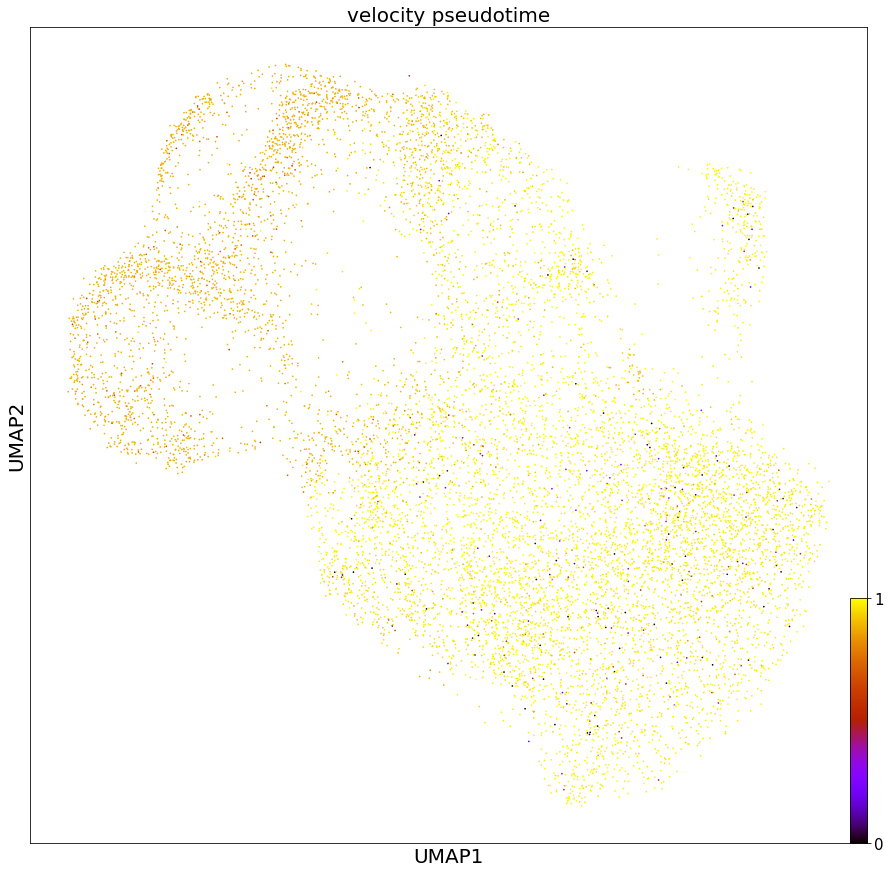

In [23]:
scv.tl.velocity_pseudotime(merge_data)
scv.pl.scatter(merge_data, color='velocity_pseudotime', cmap='gnuplot', basis = "X_umap",
               figsize = (15, 15), fontsize=20, legend_fontsize = 30, frameon=True)

## Speed and coherence

Two more useful stats: 

- The speed or rate of differentiation is given by the length of the velocity vector. 

- The coherence of the vector field (i.e., how a velocity vector correlates with its neighboring velocities) provides a measure of confidence.

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


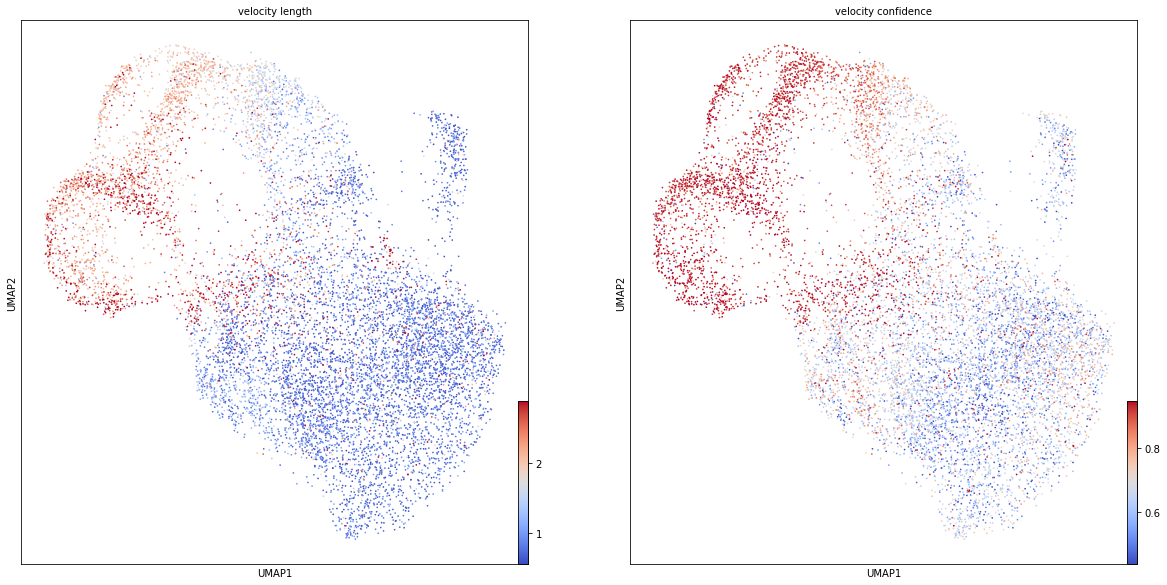

In [24]:
scv.tl.velocity_confidence(merge_data)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(merge_data, c=keys, cmap='coolwarm', perc=[5, 95], basis = "X_umap", frameon=True, 
              figsize = (10, 10))

In [25]:
df = merge_data.obs.groupby('seurat_clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

seurat_clusters,0,1,2,3,4,5,6,7,8
velocity_length,0.951002,0.862417,1.826923,2.257367,1.510451,0.805819,1.008900,2.423848,1.105000
velocity_confidence,0.618990,0.607457,0.792128,0.894036,0.760678,0.614070,0.660022,0.886865,0.658596


In [29]:
all_velodata

AnnData object with n_obs × n_vars = 26037 × 32285
    obs: 'barcode', 'batch', 'Clusters', '_X', '_Y', 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [30]:
adata

AnnData object with n_obs × n_vars = 13602 × 18175
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'name', 'stage', 'percent.mt', 'percent.ribo', 'No.Exprs', 'log10GenesPerUMI', 'nCount_decontX', 'nFeature_decontX', 'AmbientRNA', 'decontX_clusters', 'Doublet_classifications', 'percent.exclude', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'G1.Score', 'CC.Difference', 'integrated_snn_res.0.5', 'seurat_clusters', 'cluster_Izumo1r', 'plot.cluster', 'celltype', 'barcode', 'UMAP_1', 'UMAP_2', 'sample_batch'
    obsm: 'X_pca', 'X_umap'

In [40]:
tmpdf = merge_data.var
tmpdf[tmpdf["Chromosome"] == "JH584304.1"]

,Accession,Chromosome,End,Start,Strand,gene_count_corr,means,dispersions,dispersions_norm,highly_variable,velocity_gamma,velocity_qreg_ratio,velocity_r2,velocity_genes,spearmans_score,velocity_score
